In [1]:
import ROOT
import uproot
import matplotlib.pyplot as plt
import numpy as np
import awkward as ak

from sklearn.preprocessing import normalize as norm

Welcome to JupyROOT 6.30/04


In [2]:
FILE_PATH = "../Dati/Run_Co_correlations_Data_5_23_2024_Ascii_0000.root" #Relative file path
file = uproot.open(FILE_PATH)
file["tree"].show()


baselines = np.array(file["tree"]["base"].array()[1:-1]) 
charges = np.array(file["tree"]["charge"].array()[1:-1])
amp = np.array(file["tree"]["amp"].array()[1:-1])
lead_edge = np.array(file["tree"]["letime"].array()[1:-1])
t_edge = np.array(file["tree"]["tetime"].array()[1:-1])
channel= np.array(file["tree"]["ch"].array()[1:-1])
waveform = np.array(file["tree"]["pshape"].array()[1:-1])
flag    = np.array(file["tree"]["Flag"].array()[1:-1])



name                 | typename                 | interpretation                
---------------------+--------------------------+-------------------------------
ev                   | int32_t                  | AsDtype('>i4')
nch                  | int32_t                  | AsDtype('>i4')
ch                   | int32_t[]                | AsJagged(AsDtype('>i4'))
base                 | float[]                  | AsJagged(AsDtype('>f4'))
amp                  | float[]                  | AsJagged(AsDtype('>f4'))
charge               | float[]                  | AsJagged(AsDtype('>f4'))
letime               | float[]                  | AsJagged(AsDtype('>f4'))
tetime               | float[]                  | AsJagged(AsDtype('>f4'))
Flag                 | int32_t[2]               | AsDtype("('>i4', (2,))")
pshape               | float[][1024]            | AsJagged(AsDtype("('>f4', (...


In [167]:
print(waveform[0][7])

[-0.000628 -0.000153 -0.000731 ... -0.047299 -0.052765 -0.064867]


In [3]:
print(flag)

[[ 7  8]
 [ 9 12]
 [ 5  9]
 ...
 [ 5 15]
 [ 9 10]
 [ 0  5]]


In [4]:

N_ch= len(charges[0])
N_ev=len(charges)
print(N_ev, N_ch)

7452 16


In [5]:
print(N_ch)

16


(157, 2)


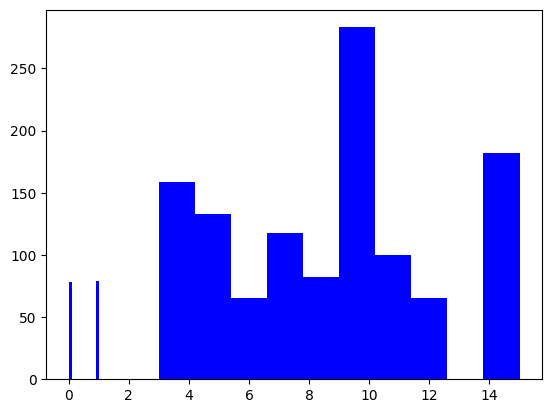

In [20]:
#posso controllare come un canale è accoppiato agli altri
ch=2
msk=np.where(flag[:,0]== ch)[0]
plt.hist(flag[msk, 1],color = "blue")
msk=np.where(flag[:,1]== ch)[0]
plt.hist(flag[msk, 0],color="blue")

print(flag[msk, :].shape)

#

ad ogni event è associata una flag, ora devo selezionare tutti gli event con una stessa flag

In [23]:
def timing_measurement(paired_wf_1, sampling, shiftR, shiftL, n_mean, thresh):
    wf_1_len = len(paired_wf_1)
    new_wf_1 = np.array(paired_wf_1).reshape([np.array(paired_wf_1).shape[0], 1, np.array(paired_wf_1).shape[1]])

    for evt in range(new_wf_1.shape[0]):
        for ch in range(new_wf_1.shape[1]):
            bsl_1 = new_wf_1[evt, ch, 0:32].mean()
            new_wf_1[evt, ch, :] = np.convolve(new_wf_1[evt, ch], [1/n_mean] * n_mean, mode = "same") - bsl_1

    new_wf_1 = -norm(-new_wf_1.reshape(-1, 1024), norm = "max", axis = 1, copy = True, return_norm = False)
    threshold = thresh

    ledges1 = np.zeros(new_wf_1.shape[0])

    for evt in range(new_wf_1.shape[0]):
        try:
            ledge= np.where(np.diff(np.sign(new_wf_1[evt] - threshold)))[0][0]
            coef = np.polyfit(new_wf_1[evt][ledge-shiftL:ledge+shiftR],np.arange(ledge-shiftL, ledge+shiftR),1)
            ledges1[evt] = np.poly1d(coef)(threshold) 
        except IndexError:
            continue

    return ledges1*sampling

In [27]:
#data una coppia e un dataset la funzione ritorna l'offset relativo alla misura di timing
def offset_and_resolution_estimation( couple, flag, waveform, sampling, shiftR, shiftL, n_mean, thresh):
    idx=np.where( (flag[:,0]==couple[0] ) & (flag[:,1]==couple[1]) )[0]
    if(len(idx)>0):
        paired_wf_1=waveform[idx][:,couple[0]]
        paired_wf_2=waveform[idx][:,couple[1]]
        timeres=timing_measurement(paired_wf_1, sampling, shiftR, shiftL, n_mean, thresh)-timing_measurement(paired_wf_2, sampling, shiftR, shiftL, n_mean, thresh)
        msk=np.where(np.abs(timeres) < 50)[0]
        return(np.mean(timeres[msk]), np.std(timeres[msk]), timeres)
    else:
        return(0,0,0)


In [29]:
offset_matrix=np.zeros((N_ch, N_ch))
def offset_matrix_filling(N_ch, flag, waveform, sampling, shiftR, shiftL, n_mean, thresh):
    for i in range(N_ch):
        for j in range(N_ch):
            tmp=offset_and_resolution_estimation([i,j], flag, waveform, sampling, shiftR, shiftL, n_mean, thresh)[0]
            offset_matrix[i][j]=tmp
    return(offset_matrix)



In [44]:
sampling=1.875
shiftR=2
shiftL=0
n_mean=8
thresh=-0.1
print(offset_and_resolution_estimation([6,7], flag, waveform, sampling, shiftR, shiftL, n_mean, thresh)[0])

-2.045190879172656


In [30]:
offset_matrix=offset_matrix_filling(N_ch, flag, waveform, sampling, shiftR, shiftL, n_mean, thresh)
print(offset_matrix)

[[ 0.          1.12875707  5.71894384  3.45970022  2.36919526  0.32086542
   3.37254115  1.98442343  1.80522933  0.44460988 -0.68006487  1.26563271
   4.28399192  0.          3.42576571  0.73344449]
 [ 0.          0.          4.58299446  2.13904631  0.85240316 -1.65355734
   1.85091076  0.38337311  0.60492122 -0.64452346 -1.63993564 -0.75522477
   2.42860119  0.          2.27642751 -0.14815642]
 [ 0.          0.          0.         -2.53044645 -4.29376735 -6.18293491
  -2.65765517 -4.70488514 -3.73020654 -5.38517115 -6.41314651 -4.40138748
  -1.7687084   0.         -2.79574643 -4.93307352]
 [ 0.          0.          0.          0.         -1.03232663 -3.57628404
   0.15723711 -2.02588228 -1.7322997  -3.05100947 -3.94734046 -2.59705702
   0.77756724  0.         -0.15761474 -2.42864036]
 [ 0.          0.          0.          0.          0.         -2.29097125
   1.16452855 -0.8511937  -0.77305615 -1.74414337 -4.3286207  -1.21186506
   1.66679806  0.          0.94927507 -1.07943647]
 [ 0.

Text(0, 0.5, 'channel')

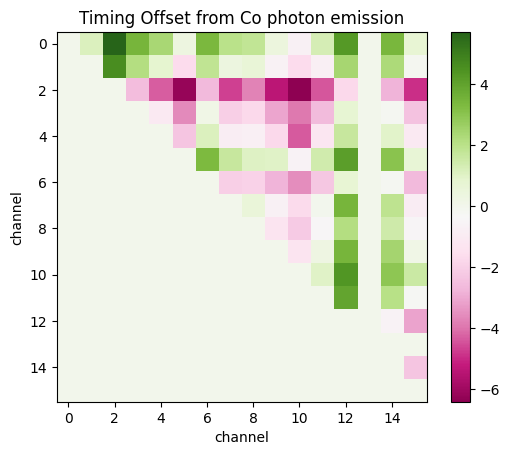

In [34]:
plt.imshow(offset_matrix, cmap='PiYG')
plt.title("Timing Offset from Co photon emission")
plt.colorbar()
plt.xlabel("channel")
plt.ylabel("channel")